In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import copy

from importlib import reload

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import scoobpsf
from scoobpsf.math_module import xp, _scipy
from scoobpsf.imshows import *
from scoobpsf import scoob

import lina 

pupil_diam = 6.75*u.mm 
lyot_diam = 8.6*u.mm

wavelength_c = 632.8e-9*u.m # central wavelength
npix = 256
oversample = 32
npix = 512
oversample = 16

reload(scoobpsf.agpm)
vortex = scoobpsf.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2.0)
wfs_lyot_stop = poppy.InverseTransmission(lyot_stop)


In [34]:
model.lyot_stop_diam

AttributeError: 'SCOOBM' object has no attribute 'lyot_stop_diam'

In [36]:
reload(scoob)
model = scoob.SCOOBM(npix=npix, oversample=oversample)

# static_wfe = lina.utils.generate_wfe(model.pupil_diam, wavelength=500*u.nm,
#                                     opd_index=2.75, amp_index=3.0, 
#                                     opd_seed=1234, amp_seed=12345,
#                                     opd_rms=25*u.nm, amp_rms=0.05,
#                                     npix=model.npix, oversample=model.oversample,
#                                     plot=True)

# wfe_amp = xp.abs(static_wfe)
# wfe_opd = xp.angle(static_wfe)*model.wavelength_c.to_value(u.m)/2/np.pi

wfe_amp = xp.ones((model.N, model.N))
wfe_opd = xp.zeros((model.N, model.N))

WFE = poppy.ArrayOpticalElement(transmission=copy.copy(wfe_amp), opd=copy.copy(wfe_opd),
                                 pixelscale=model.pupil_diam/(model.npix*u.pix))

model.WFE = WFE

model.LYOT = lyot_stop


No OPD data implemented into model.
Using default Gaussian influence function.
Including factor of 2 from reflection when computing OPD.


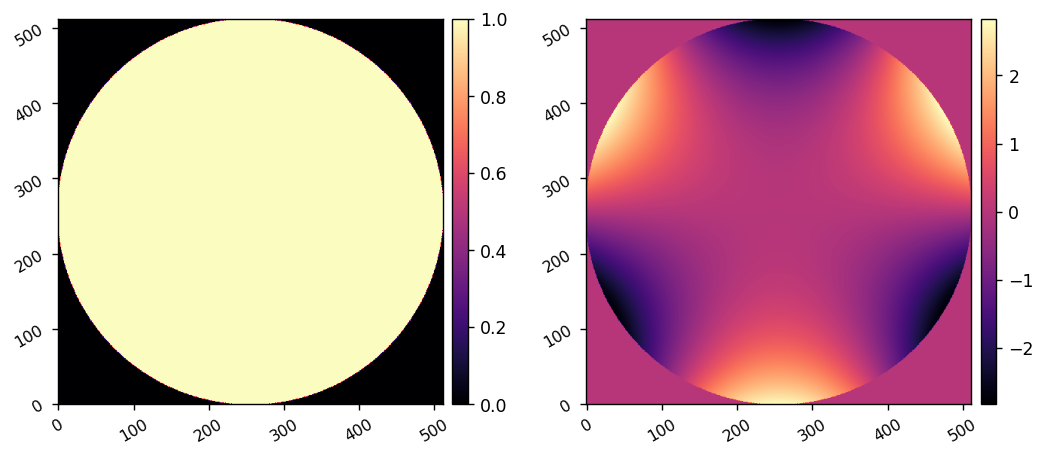

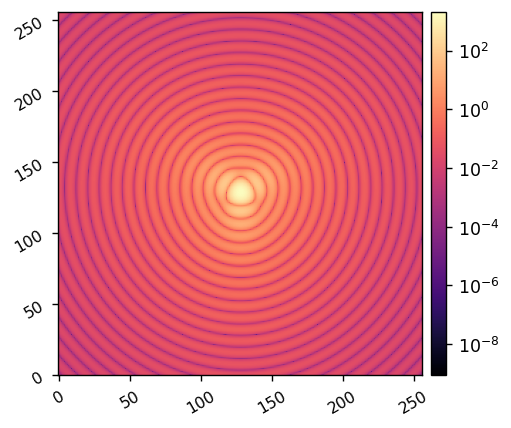

In [37]:
nmodes = 25
zmodes = lina.utils.create_zernike_modes(model.pupil_mask, nmodes=nmodes+1)[1:]
imshow2(model.pupil_mask, zmodes[7])

trefoil = 20e-9*utils.pad_or_crop(zmodes[7], model.N)

model.WFE.opd += trefoil

im = model.snap()
imshow1(im, lognorm=True)
model.reset_dm()

model.WFE.opd -=trefoil



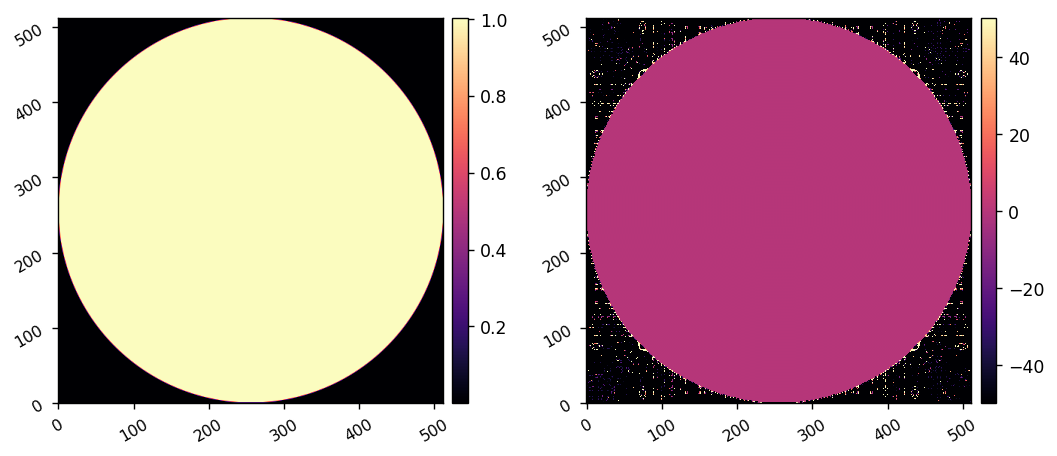

In [38]:
model.return_pupil = True
pupil_wf = model.calc_wf()
model.return_pupil = False
imshow2(xp.abs(pupil_wf), xp.angle(pupil_wf)*model.wavelength.to_value(u.nm)/(2*np.pi), 
        npix=model.npix, vmin2=-50, vmax2=50)


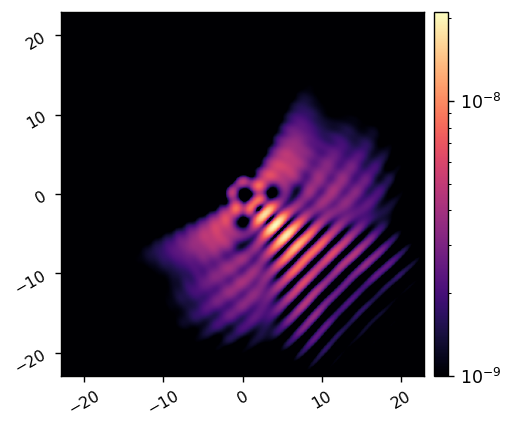

In [39]:
model.FPM = None
model.Imax_ref = model.snap().max()

ref_psf = model.snap()

model.FPM = vortex

ref_im = model.snap()
imshow1(ref_im, lognorm=True, vmin=1e-9, pxscl=model.psf_pixelscale_lamD)

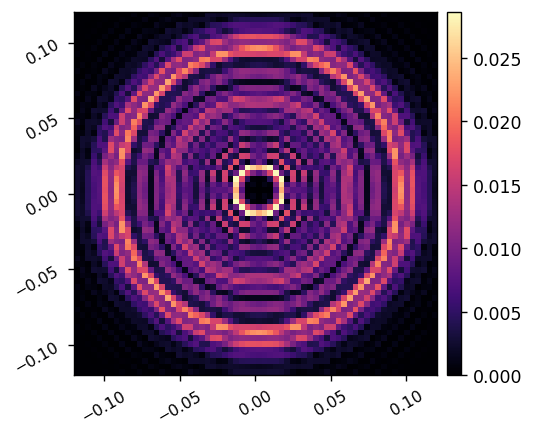

In [40]:
model.use_llowfsc = True
model.fl_llowfsc_lens = 100*u.mm
model.llowfsc_defocus = 0.9*u.mm
model.nllowfsc = 64

model.FPM = vortex
model.LYOT = wfs_lyot_stop

model.reset_dm()
im = model.snap()
imshow1(im, pxscl=model.llowfsc_pixelscale.to(u.mm/u.pix))


In [41]:
model.use_llowfsc = False
model.LYOT = lyot_stop
coro_im = model.snap()
model.use_llowfsc = True
model.LYOT = wfs_lyot_stop

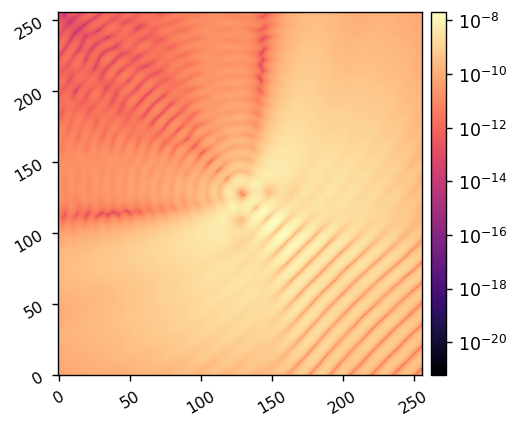

In [42]:
imshow1(coro_im, lognorm=True)

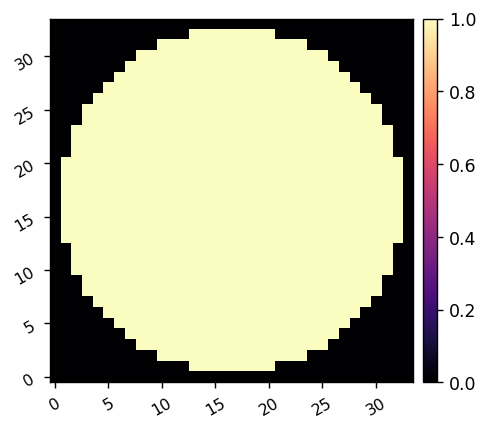

array(812)

In [43]:
dm_mask = xp.ones((model.Nact,model.Nact), dtype=bool)
xx = (xp.linspace(0, model.Nact-1, model.Nact) - model.Nact/2 + 1/2)
x,y = xp.meshgrid(xx,xx)
r = xp.sqrt(x**2 + y**2)
dm_mask[r>(model.Nact-2)/2] = 0
imshow1(dm_mask)
dm_mask.sum()

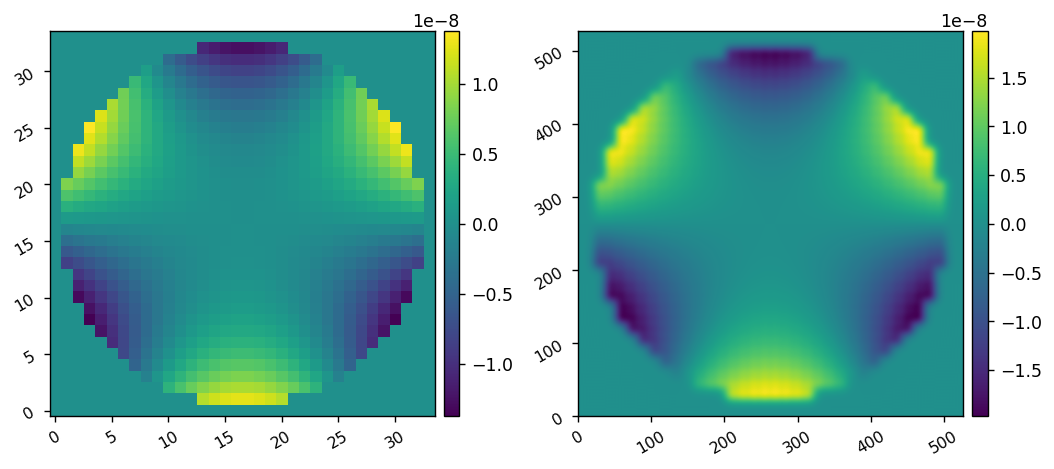

In [44]:
dm_zernikes = lina.utils.create_zernike_modes(dm_mask, nmodes=25 + 1)[1:]
model.set_dm(dm_zernikes[7]*5e-9)
imshow2(dm_zernikes[7]*5e-9, model.DM.get_surface(), cmap1='viridis', cmap2='viridis')
model.reset_dm()


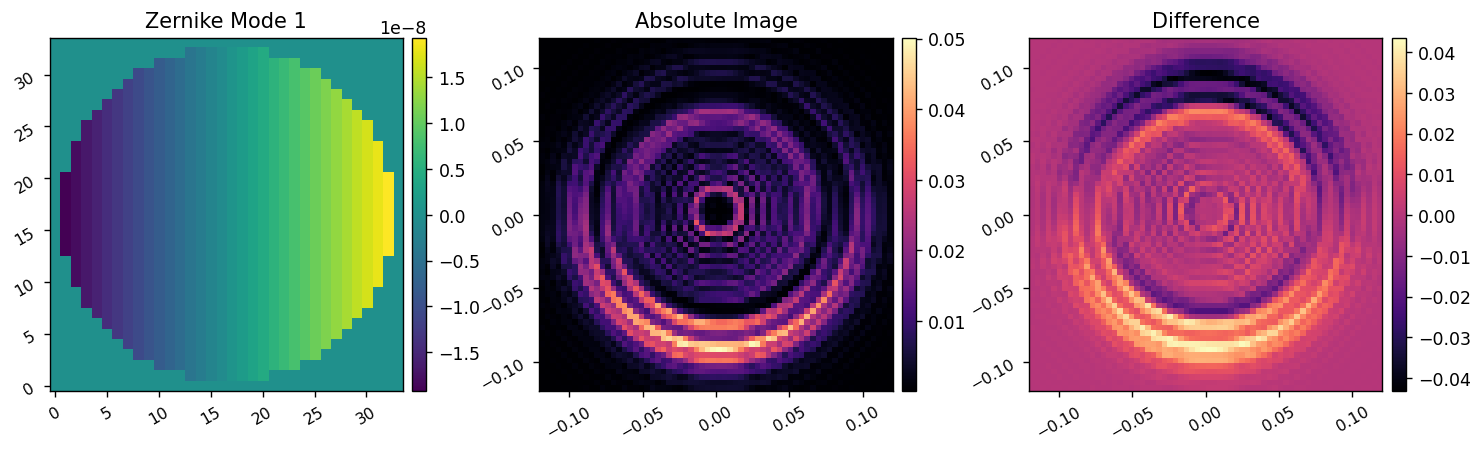

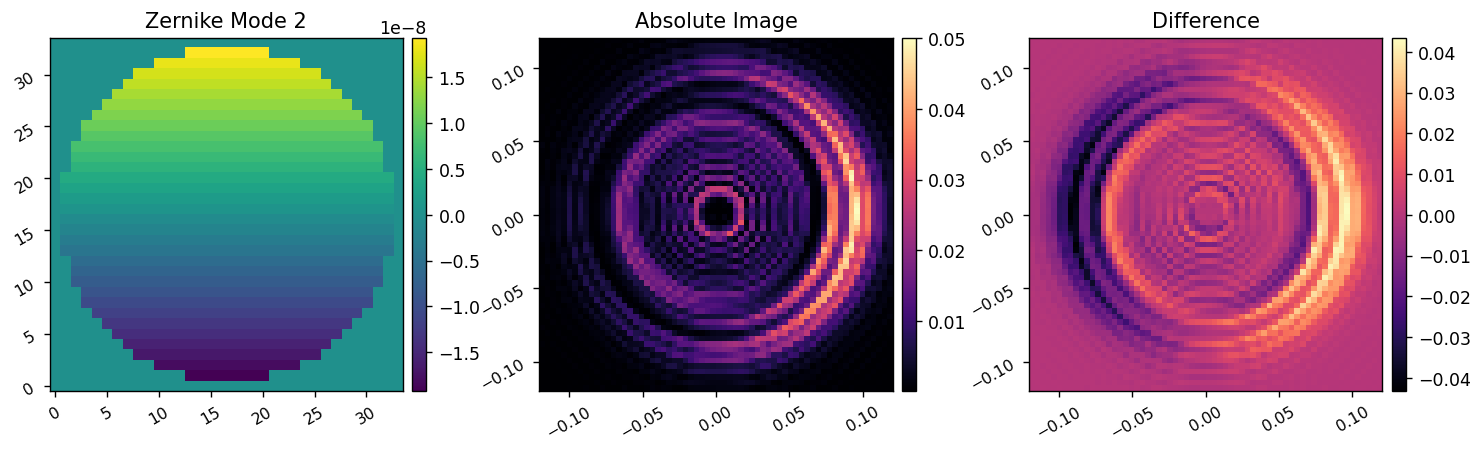

In [46]:
amp = 10e-9

im_ref = model.snap()

N = 2
responses = xp.zeros((N, model.nllowfsc**2))
for i in range(N):
    mode = dm_zernikes[i]
    # model.RETRIEVED = poppy.ArrayOpticalElement(opd=mode*1e-8, pixelscale=model.pupil_diam/(2*model.npix*u.pix))
    # im_pos = model.snap()

    model.set_dm(amp*mode)
    im_pos = model.snap()
    model.add_dm(-amp*mode)
    
    # diff = im_pos-im_ref
    # responses[i] = diff.flatten()/amp
    
    model.add_dm(-amp*mode)
    im_neg = model.snap()
    model.add_dm(amp*mode)

    diff = im_pos - im_neg
    responses[i] = diff.flatten()/(2*amp)

    imshow3(amp*mode, im_pos, diff, f'Zernike Mode {i+1}', 'Absolute Image', 'Difference', 
            pxscl2=model.llowfsc_pixelscale.to(u.mm/u.pix), pxscl3=model.llowfsc_pixelscale.to(u.mm/u.pix), 
            cmap1='viridis')

response_matrix = responses.T

In [12]:
U, s, Vt = xp.linalg.svd(response_matrix, full_matrices=False)
s.max()/s.min()

array(1.00003924)

In [47]:
# control_matrix = lina.utils.beta_reg(response_matrix, -10)
control_matrix = lina.utils.TikhonovInverse(response_matrix, 1e-15)

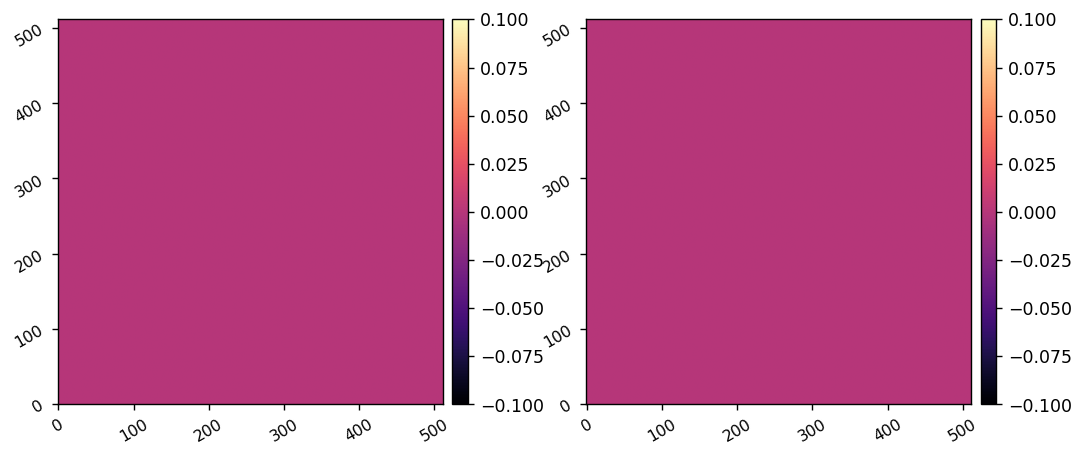

In [48]:
model.reset_dm()
model.WFE.opd = copy.copy(wfe_opd)
imshow2(wfe_opd, model.WFE.opd, npix=model.npix)

1.7657778683603102e-08 -2.515900700003357e-09
1.7657778683603102e-08 2.515900700003357e-09
1.7836112367087887e-08 1.7836112367087887e-08


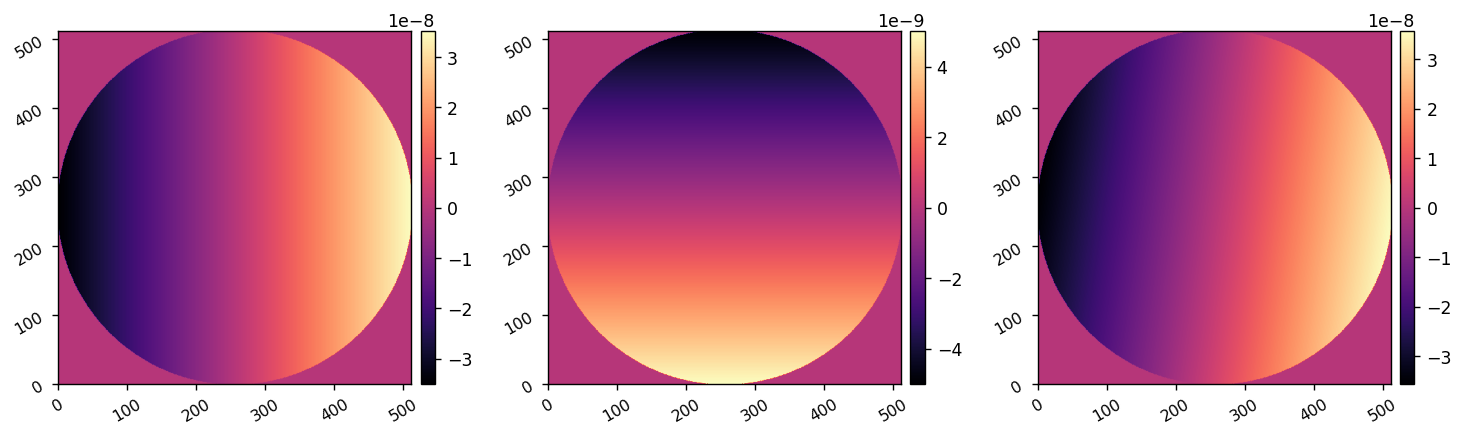

In [49]:
pointing_error_time_series = xp.array(fits.getdata('pointing_error_time_series.fits'))
times = pointing_error_time_series[0]
Nt = times.shape[0]
coeff = pointing_error_time_series[1:] * 1e-9

pointing_modes = copy.copy(zmodes[:2]).reshape(2, npix**2).T

i = 250
print(coeff[0,i], coeff[1,i])
tip = coeff[0,i]*pointing_modes[:,0].reshape(npix,npix)
tilt = coeff[1,i]*pointing_modes[:,1].reshape(npix,npix)
wfe = pointing_modes.dot(xp.array(coeff[:,i])).reshape(npix,npix)

print(np.sqrt(np.mean(np.square(tip[model.pupil_mask]))), np.sqrt(np.mean(np.square(tilt[model.pupil_mask]))))
print(xp.sqrt(coeff[0,i]**2 + coeff[1,i]**2), np.sqrt(np.mean(np.square(wfe[model.pupil_mask]))))
imshow3(tip, tilt, wfe)


In [15]:
print(np.sqrt(np.mean(np.square(coeff[0]))), np.sqrt(np.mean(np.square(coeff[1]))))

offset = np.sqrt(coeff[0]**2 + coeff[1]**2)
print(np.sqrt(np.mean(np.square(offset))))

1.0000000000000004e-08 1e-08
1.4142135623730954e-08


In [ ]:

rmss = xp.zeros(Nt)
for i in range(len(times)):
    wfe = pointing_modes.dot(coeff[:,i]).reshape(npix,npix)
    rmss[i] = xp.sqrt(xp.mean(xp.square(wfe[model.pupil_mask])))


In [17]:
xp.sqrt(xp.mean(xp.square(rmss)))

array(4.3969028e-09)

In [133]:
N = 300
pointing_wfe = xp.zeros((N, npix, npix))
for i in range(N):
    a = xp.array(coeff[:,5*i])
    wfe = pointing_modes.dot(a).reshape(npix,npix)
    pointing_wfe[i] = wfe
    # imshow1(wfe)

In [134]:
import matplotlib.pyplot as plt
plt.rcParams['image.origin']='lower'

import matplotlib
from matplotlib.animation import FFMpegWriter, PillowWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['animation.html'] = 'html5'
plt.rcParams.update({'image.origin': 'lower',
                     'image.interpolation':'nearest'})

def create_anim(arrs1):
    numframes = arrs1.shape[0]
    print(numframes)

    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(5,5),dpi=125)
    
    im1 = ax.imshow(arrs1[0,:,:],)
    im1_title = ax.set_title(f'WFE {1:d}', fontsize = 18)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.075)
    cbar = fig.colorbar(im1, cax=cax)

    def animate(i):
        im1.set_data(arrs1[i,:,:])
        im1_title.set_text(f'WFE {1:d}')
        im1.set_clim(vmin=np.min(arrs1[i,:,:]), vmax=np.max(arrs1[i,:,:]))

    anim = matplotlib.animation.FuncAnimation(fig, animate, frames=numframes, )
    return anim

In [138]:
control_matrix[:2].shape

(2, 4096)

In [40]:
reload(lina.llowfsc)
lina.llowfsc.test_run

<function lina.llowfsc.test_run(sysi, ref_im, control_matrix, control_modes, time_series_coeff, zernike_modes, plot=False)>

In [50]:
Ncoeff = 10

In [59]:
coeff[:,:Ncoeff].shape

(2, 10)

In [30]:
from scoobpsf import imshows
reload(imshows)


<module 'scoobpsf.imshows' from '/home/kianmilani/Projects/scoob-psf/scoobpsf/imshows.py'>

(1156, 2) (262144, 2)
1
(512, 512) (512, 512)


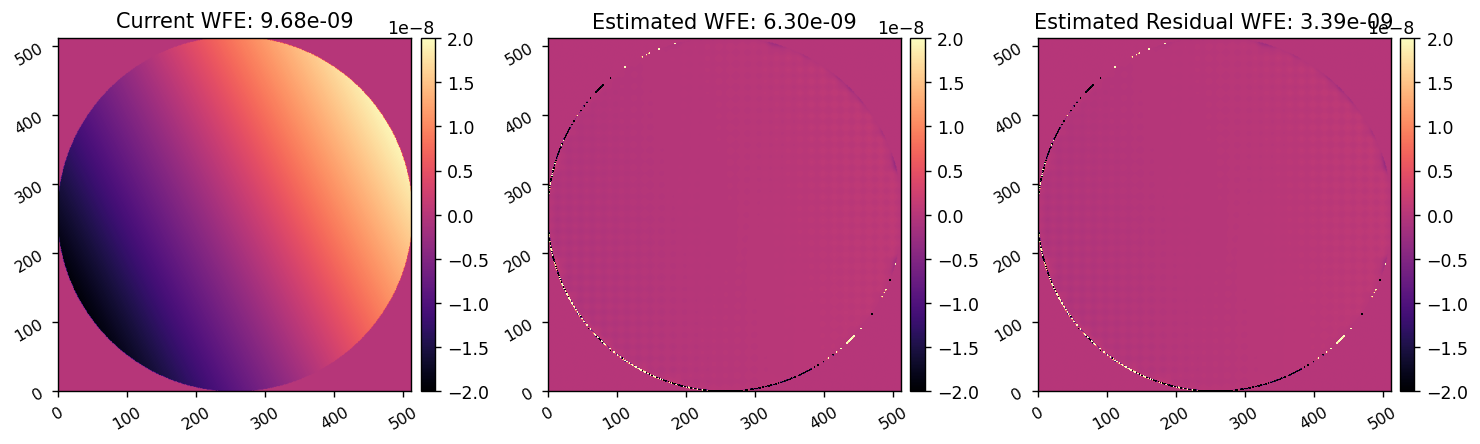

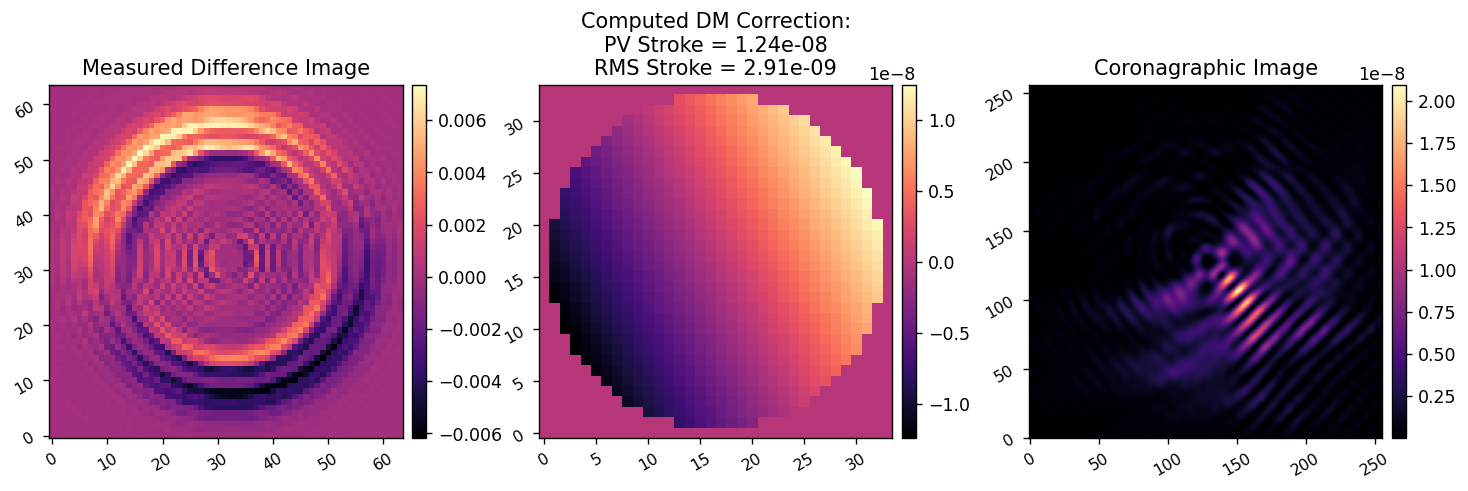

1
(512, 512) (512, 512)


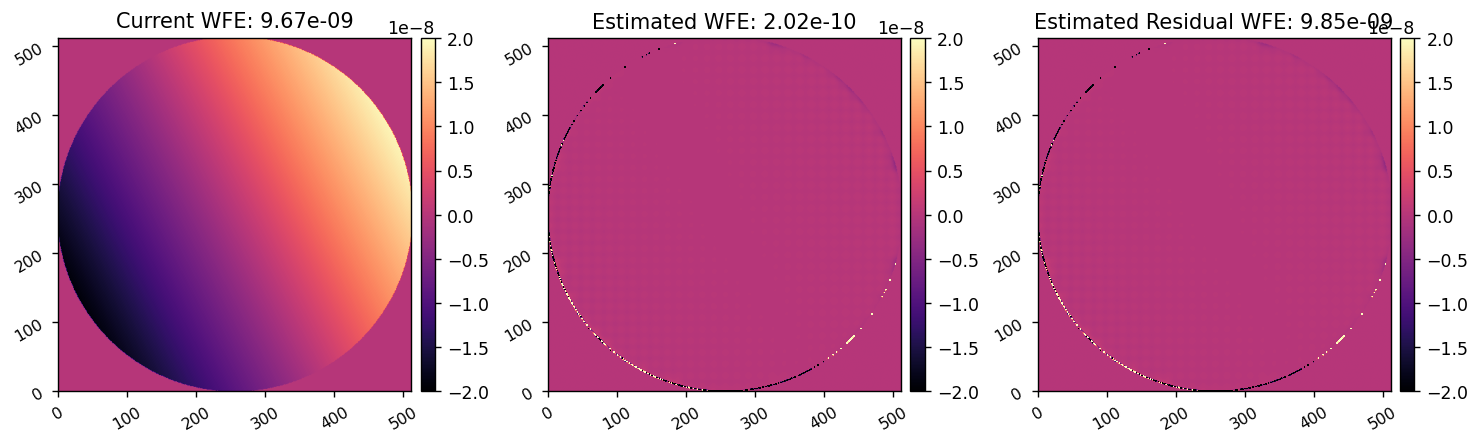

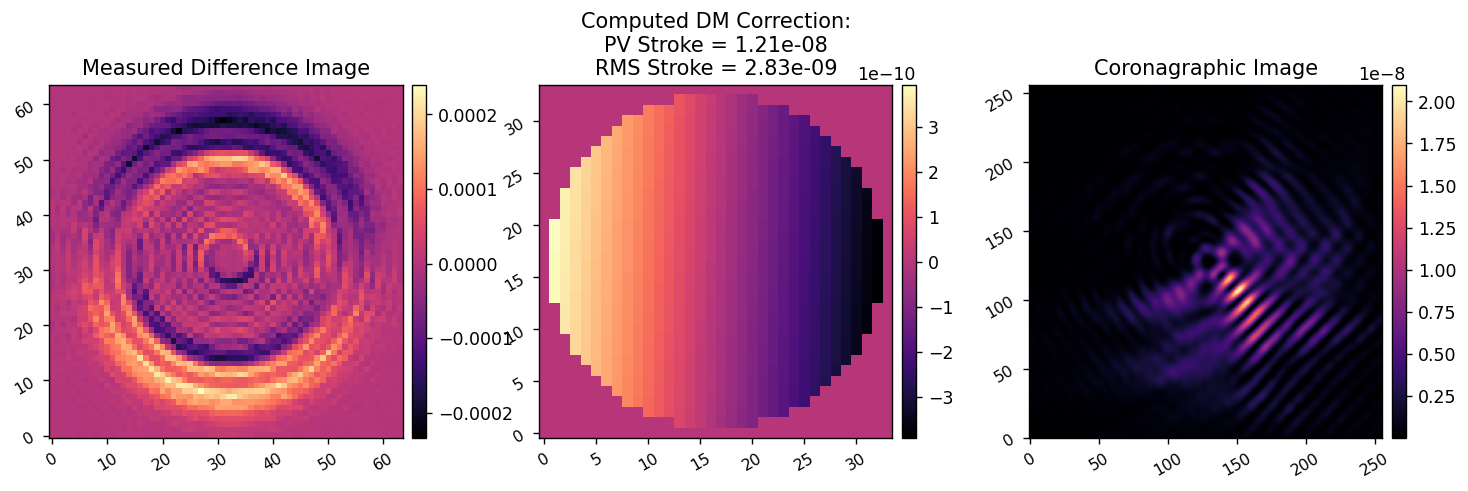

1
(512, 512) (512, 512)


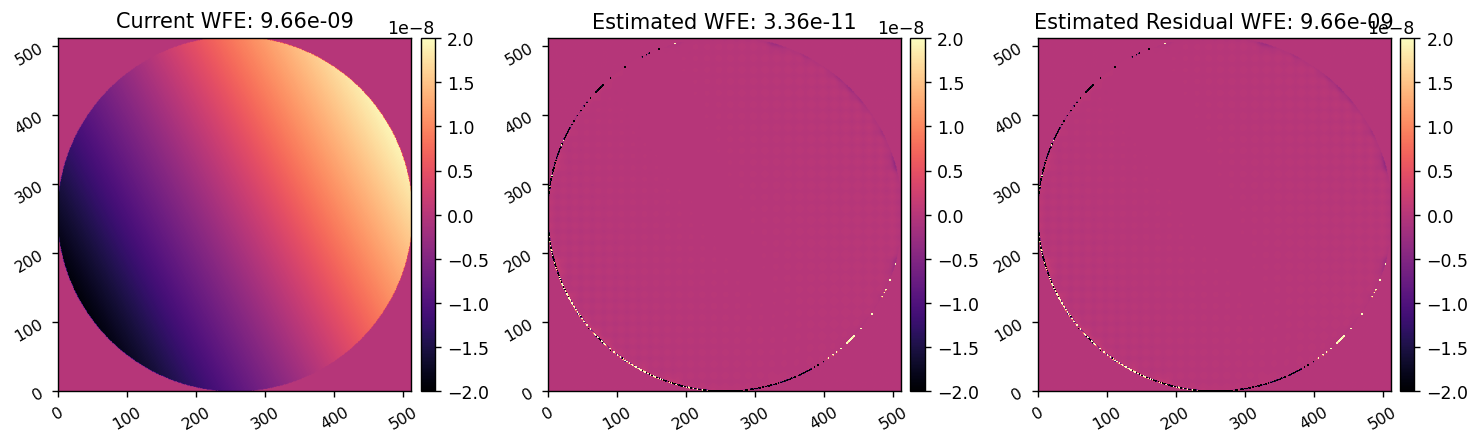

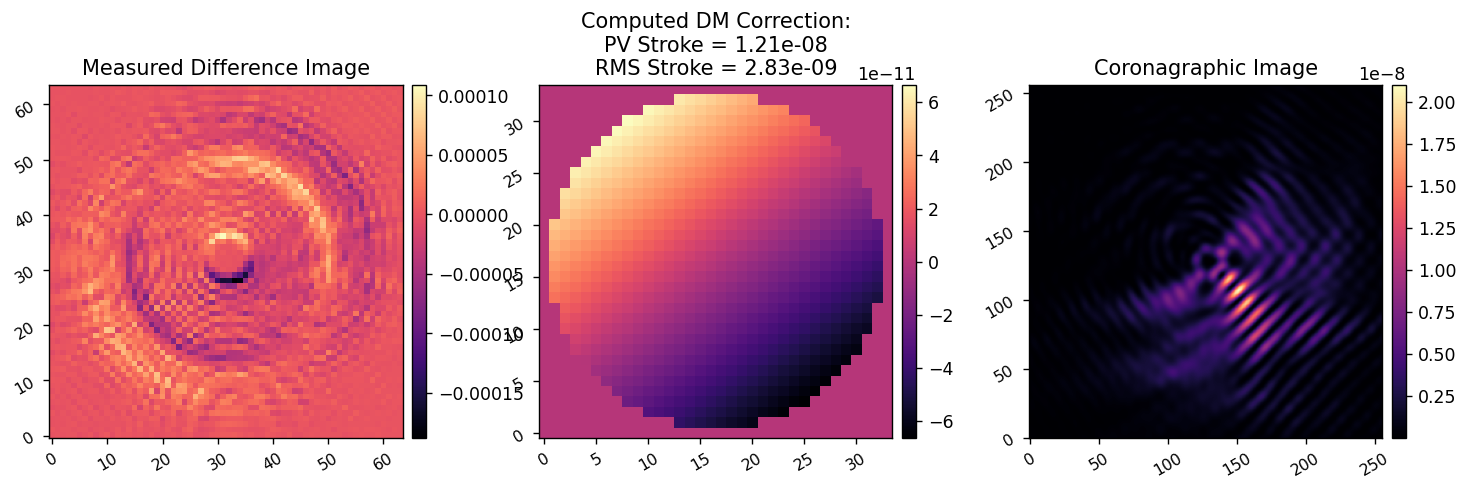

1
(512, 512) (512, 512)


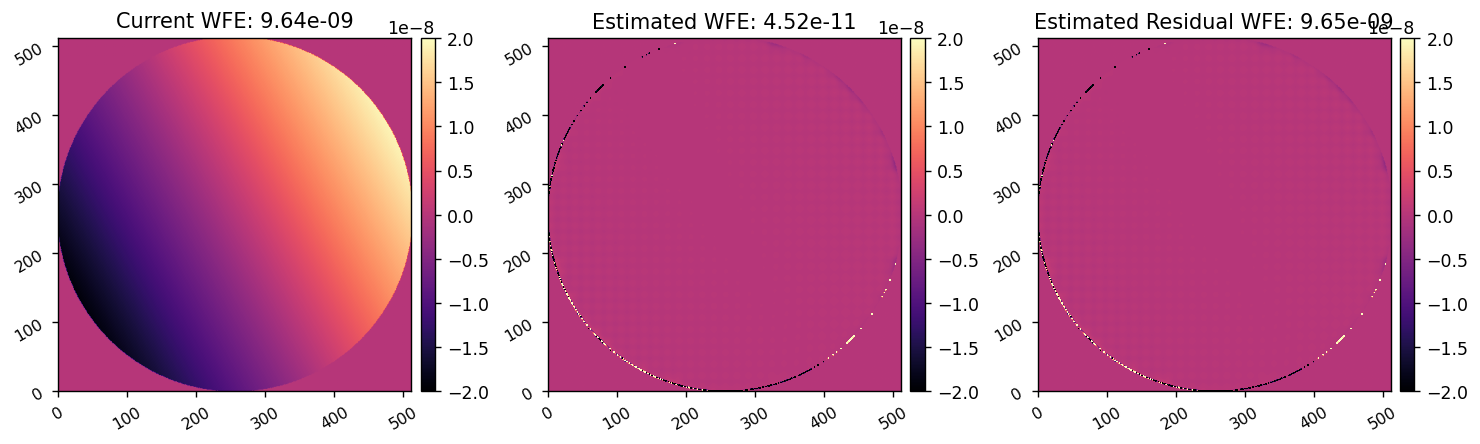

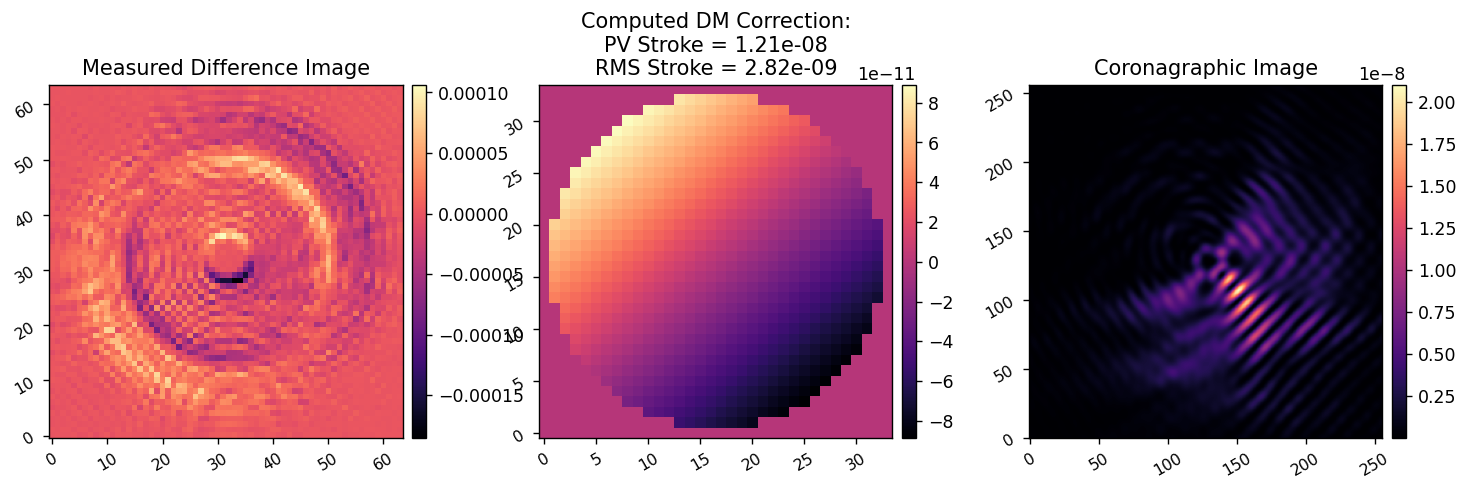

1
(512, 512) (512, 512)


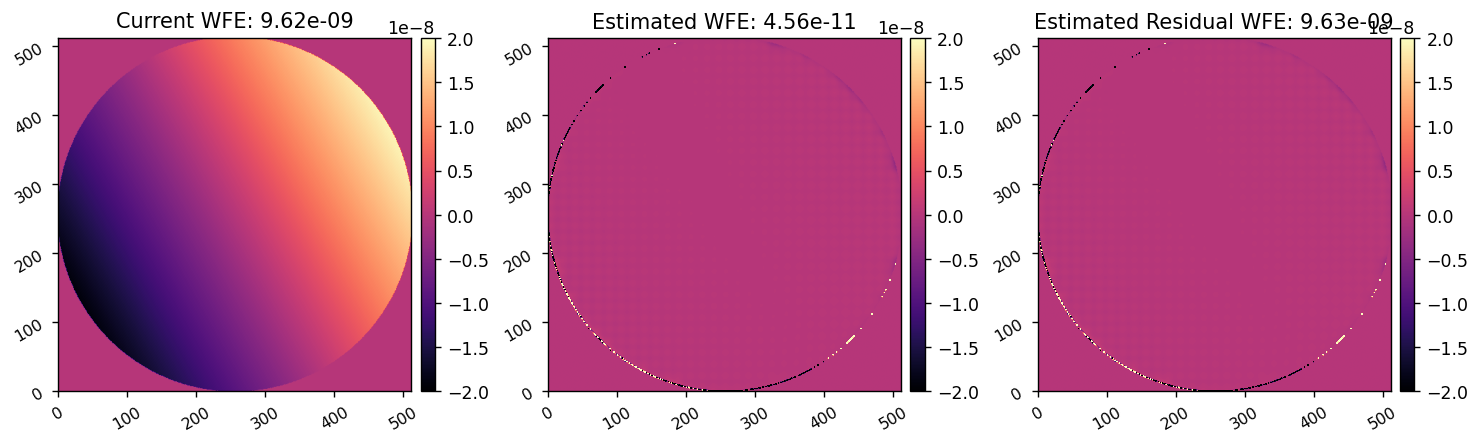

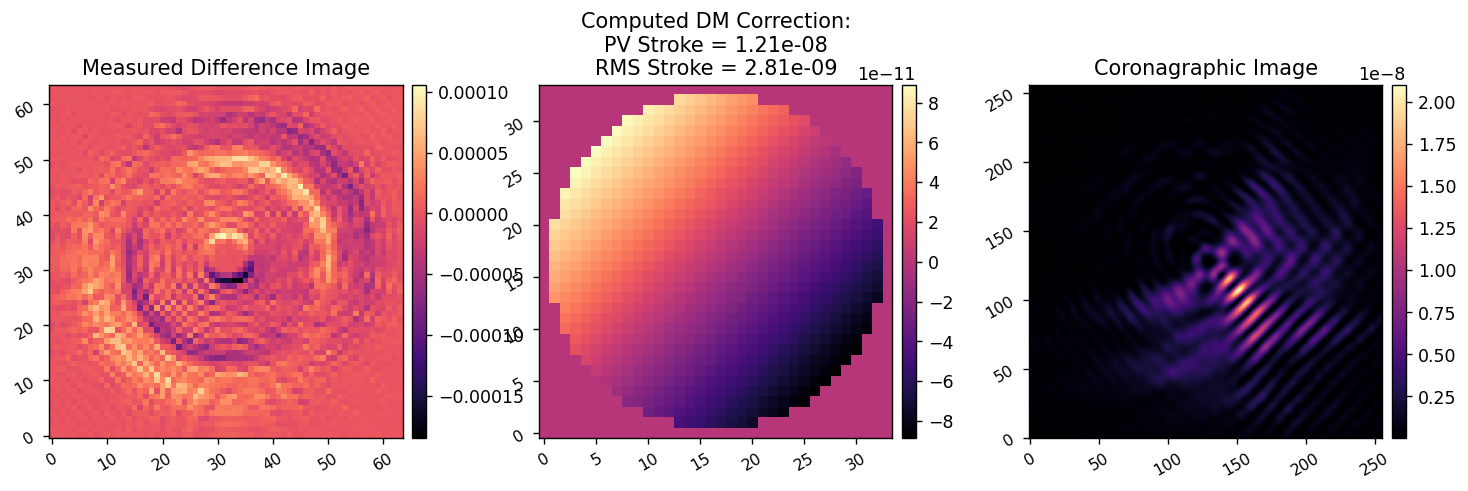

1
(512, 512) (512, 512)


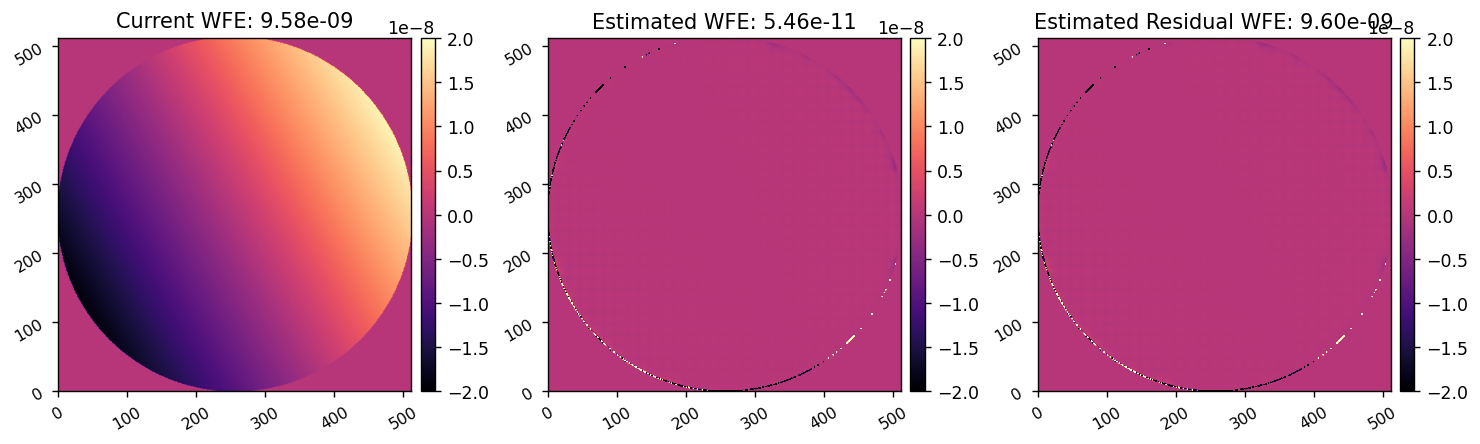

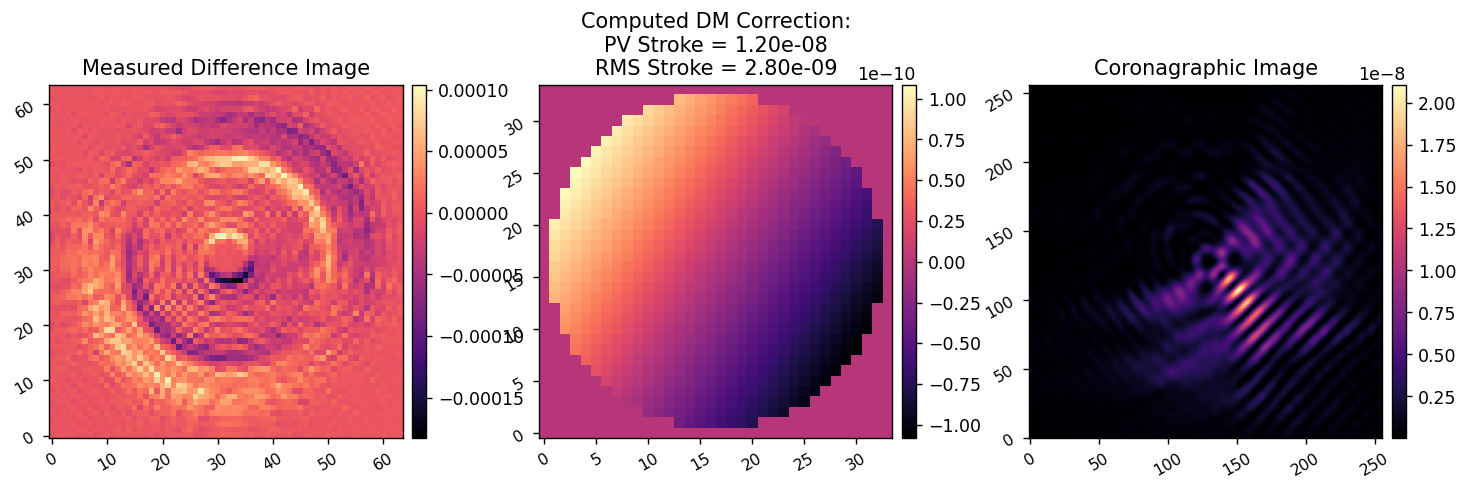

1
(512, 512) (512, 512)


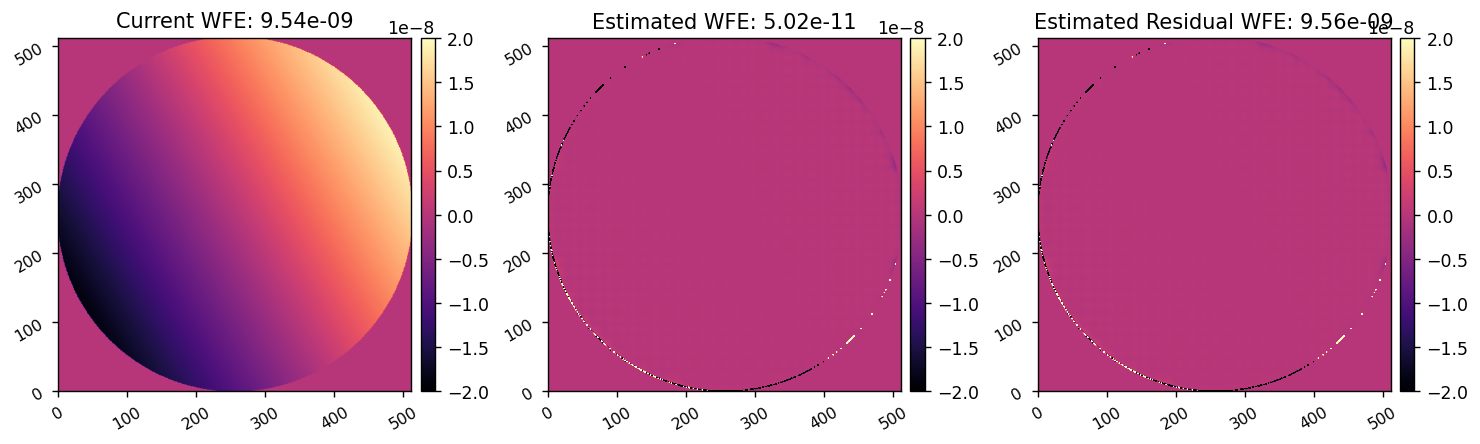

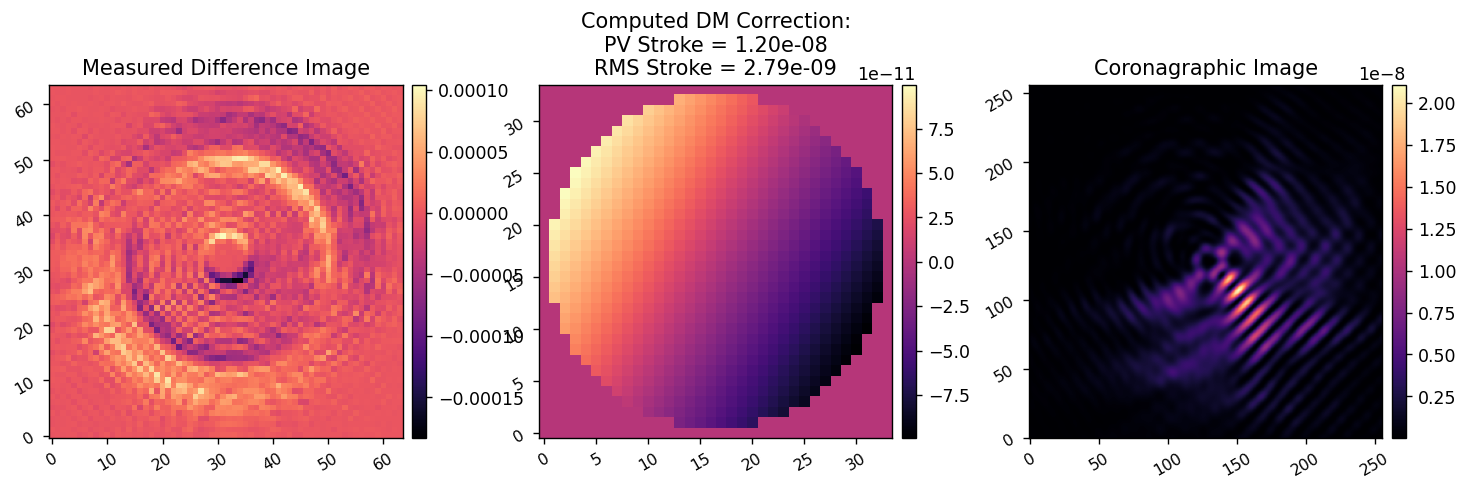

1
(512, 512) (512, 512)


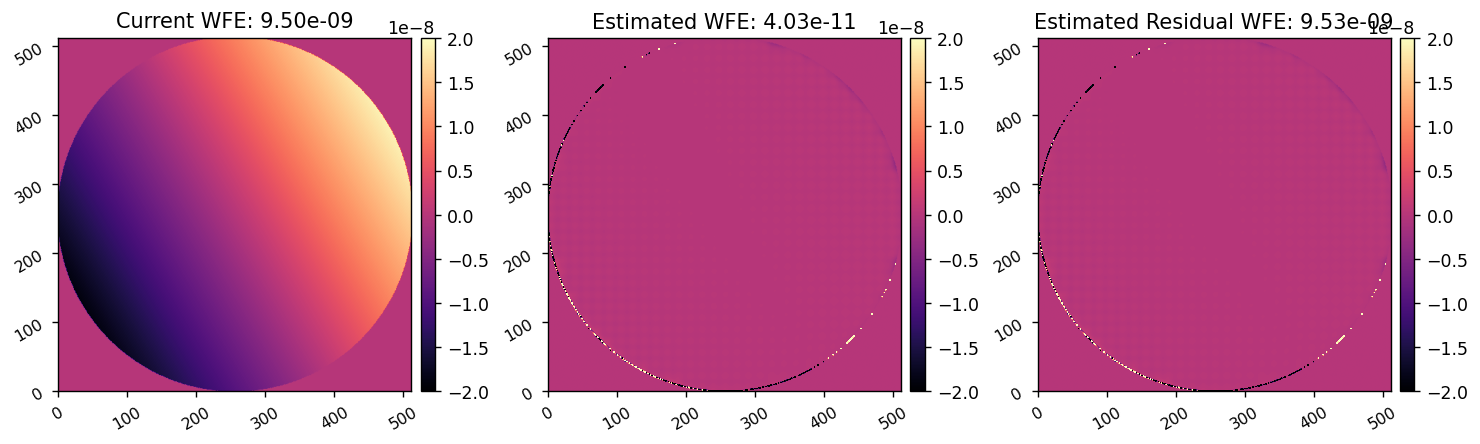

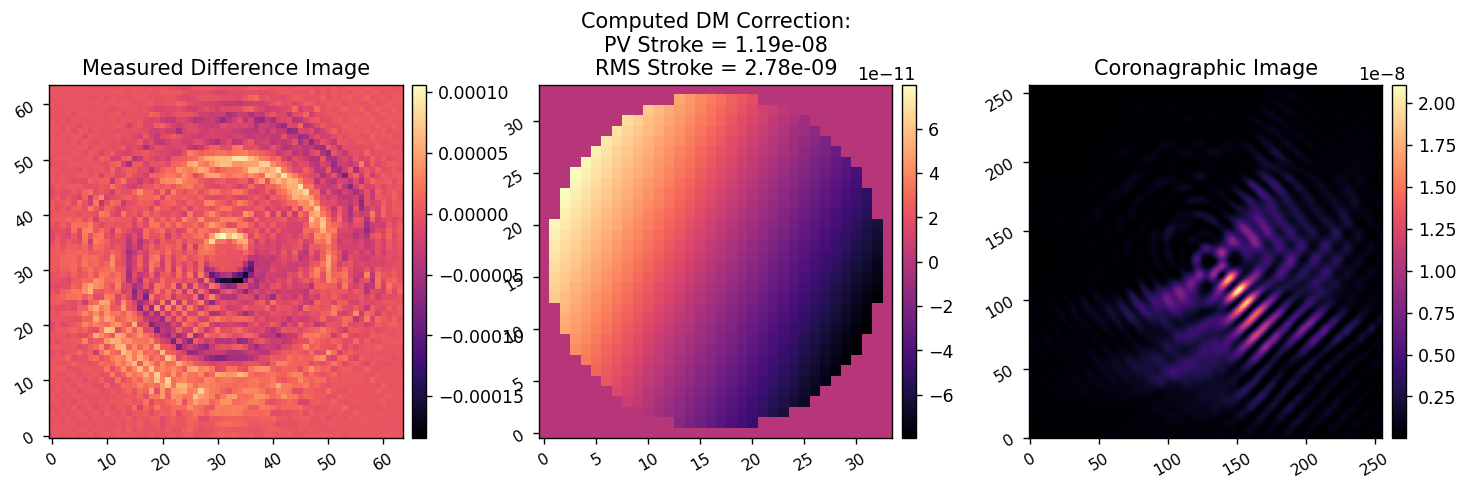

1
(512, 512) (512, 512)


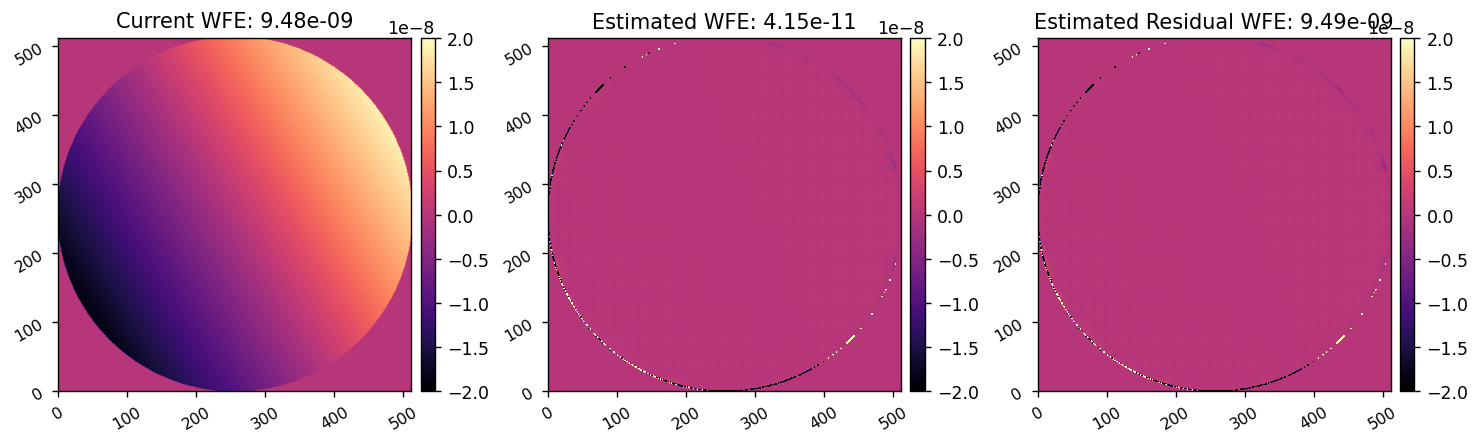

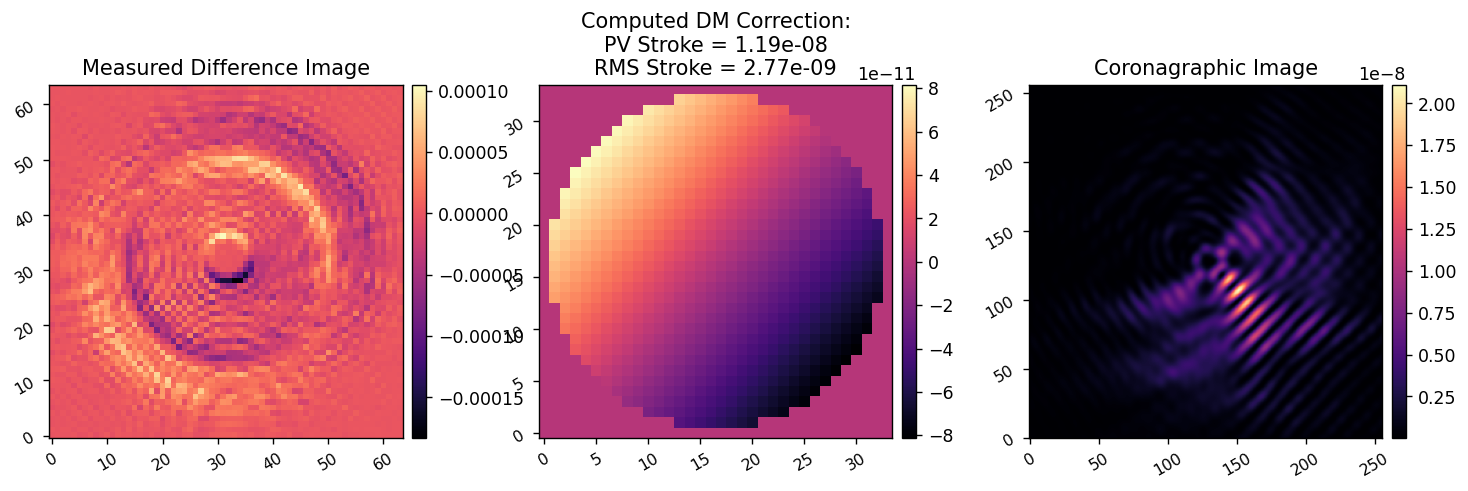

1
(512, 512) (512, 512)


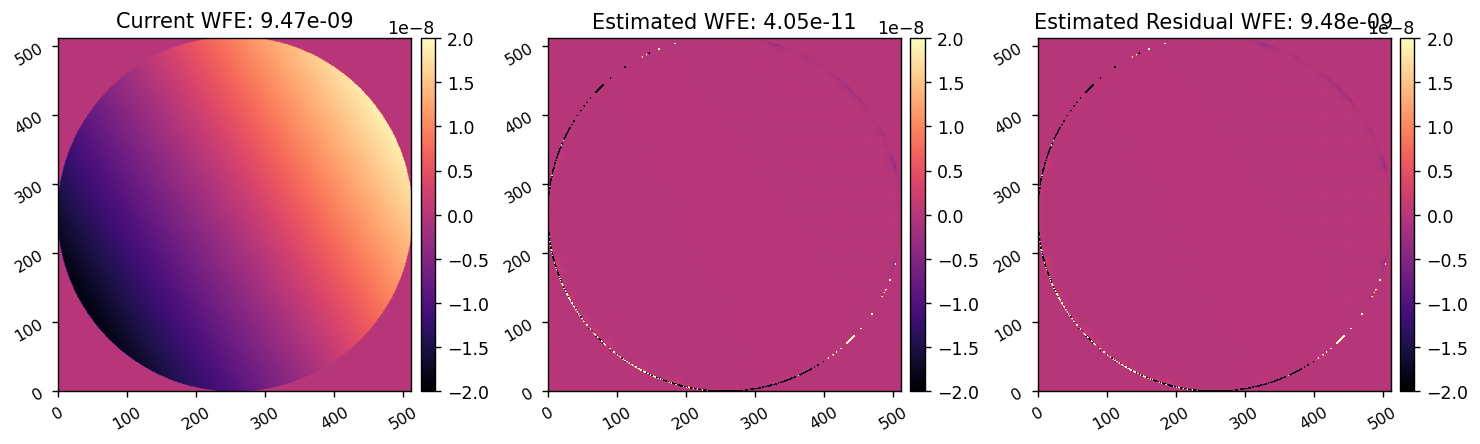

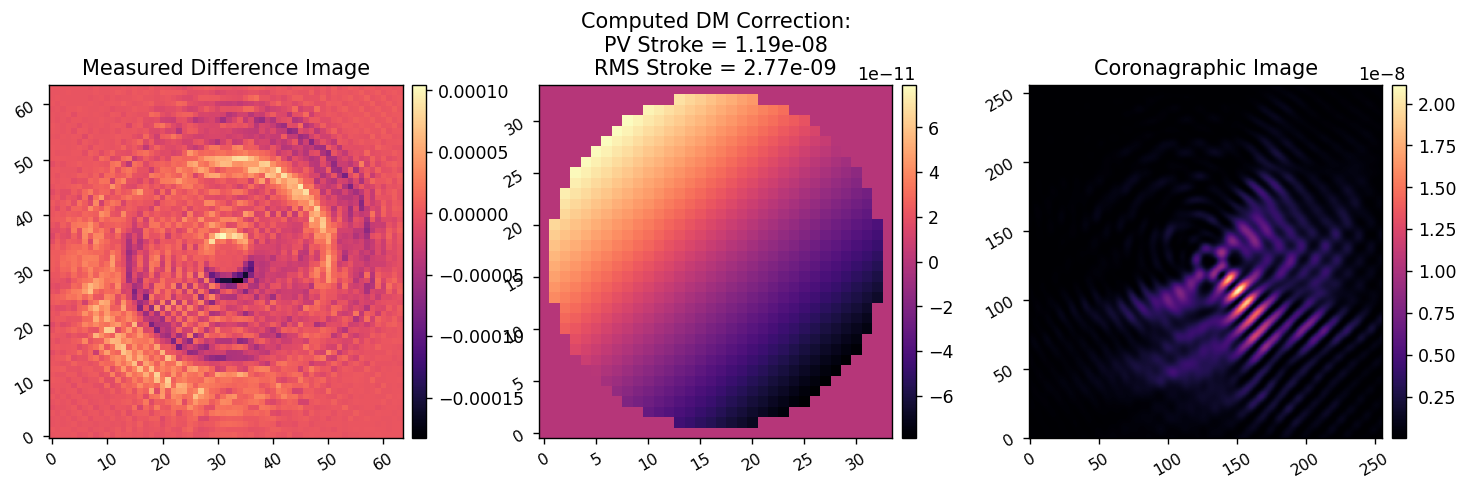

In [52]:
reload(lina)
reload(lina.llowfsc)

Ncoeff = 10

model.reset_dm()
model.WFE.opd = copy.copy(wfe_opd)

lina.llowfsc.test_run(model, 
                      ref_im=im_ref, 
                      control_matrix=control_matrix[:N], 
                      control_modes=dm_zernikes[:N],
                      time_series_coeff=coeff[:,:Ncoeff], 
                      zernike_modes=zmodes[:N], 
                      plot=True, 
                      )

In [53]:
delt = times[1]-times[0]
1/delt

array(200.)

In [ ]:
create_anim(ensure_np_array(pointing_wfe))